In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(knitr)
library(stringr)
library(DT)
library(plotly)
library(arules)
library(arulesViz)
library(visNetwork)
library(igraph)
library(kableExtra)
library(RColorBrewer)

symptom_data = read.table(file = '../../data/nCoV2019/for_use/symptoms.tsv', sep = '\t', header = TRUE,
                           row.names = 1)

# Change all columns to be of type "logical"
for(i in c(1:ncol(symptom_data))) {
    symptom_data[,i] <- as.logical(symptom_data[,i])
}

# Adjust names

names(symptom_data) <- gsub(".", " ", names(symptom_data), fixed=TRUE)

head(symptom_data)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: Matrix


Attaching package: ‘arules’


The following object is masked from ‘package:dplyr’:

    recode


The following objects are masked from ‘package:base’:

    abbreviate, write


Loading required package: grid

Registered S3 method overwritten by 'seriation':
  method         from 
  reorder.hclust gclus


Attaching package: ‘igraph’


The following object is masked from ‘package:arules’:

    union


The following object is masked fro

,abdominal pain,aches,aching muscles,acute coronary syndrome,acute myocardial infarction,acute pharyngitis,acute renal failure,acute respiratory disease,acute respiratory distress,acute respiratory failure,⋯,sweating,systemic weakness,toothache,transient fatigue,unwellness,vomiting,weak,weakness,wheezing,yes
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
16,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE
137,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
151,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
164,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
224,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
379,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE


# Convert data frame to binary transaction matrix

In [2]:
symptom_data_transactions <- as(symptom_data, "transactions")
summary(symptom_data_transactions)

transactions as itemMatrix in sparse format with
 1520 rows (elements/itemsets/transactions) and
 142 columns (items) and a density of 0.01336175 

most frequent items:
      fever       cough sore throat     fatigue        mild     (Other) 
       1003         562         120          76          76        1047 

element (itemset/transaction) length distribution:
sizes
  1   2   3   4   5   6 
693 435 280  85  21   6 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.897   3.000   6.000 

includes extended item information - examples:
          labels      variables levels
1 abdominal pain abdominal pain   TRUE
2          aches          aches   TRUE
3 aching muscles aching muscles   TRUE

includes extended transaction information - examples:
  transactionID
1            16
2           137
3           151

# Mine rules/itemsets

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.66    0.1    1 none FALSE            TRUE       5   0.007      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 10 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[142 item(s), 1520 transaction(s)] done [0.00s].
sorting and recoding items ... [29 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [24 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


set of 24 rules 

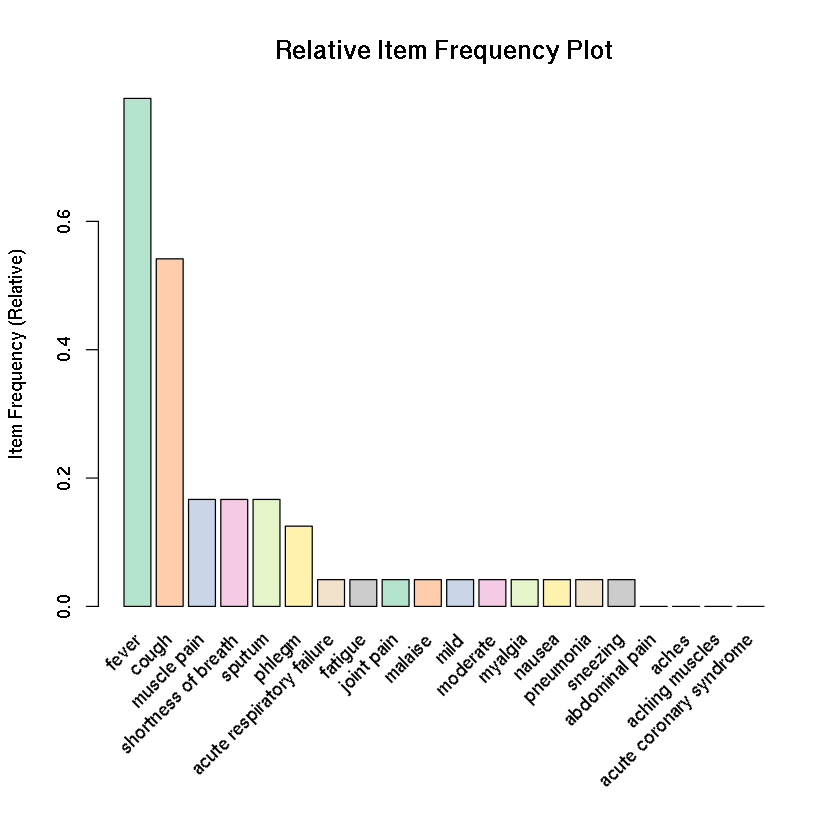

In [23]:
symptom_rules <- apriori(symptom_data_transactions, parameter=list(support=0.007, confidence=0.66, target="rules"))
symptom_rules

arules::itemFrequencyPlot(items(symptom_rules),
    topN=20,
    col=brewer.pal(8,'Pastel2'),
    main='Relative Item Frequency Plot',
    type="relative",
    ylab="Item Frequency (Relative)")

In [8]:
inspect(symptom_rules)

     lhs                                   rhs           support     confidence
[1]  {difficulty breathing}             => {fever}       0.005263158 0.8000000 
[2]  {septic shock}                     => {pneumonia}   0.005921053 0.9000000 
[3]  {acute respiratory failure}        => {pneumonia}   0.007894737 0.9230769 
[4]  {bone pain}                        => {cough}       0.006578947 1.0000000 
[5]  {bone pain}                        => {fever}       0.006578947 1.0000000 
[6]  {body ache}                        => {cough}       0.005263158 0.8000000 
[7]  {weakness}                         => {fever}       0.006578947 0.8333333 
[8]  {between others}                   => {muscle pain} 0.006578947 1.0000000 
[9]  {between others}                   => {cough}       0.006578947 1.0000000 
[10] {between others}                   => {fever}       0.006578947 1.0000000 
[11] {nasal congestion}                 => {fever}       0.005921053 0.8181818 
[12] {sneezing}                         

# Itemsets

Eclat

parameter specification:
 tidLists support minlen maxlen            target   ext
    FALSE    0.01      2     10 frequent itemsets FALSE

algorithmic control:
 sparse sort verbose
      7   -2    TRUE

Absolute minimum support count: 15 

create itemset ... 
set transactions ...[142 item(s), 1520 transaction(s)] done [0.00s].
sorting and recoding items ... [25 item(s)] done [0.00s].
creating sparse bit matrix ... [25 row(s), 1520 column(s)] done [0.00s].
writing  ... [29 set(s)] done [0.00s].
Creating S4 object  ... done [0.00s].


To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



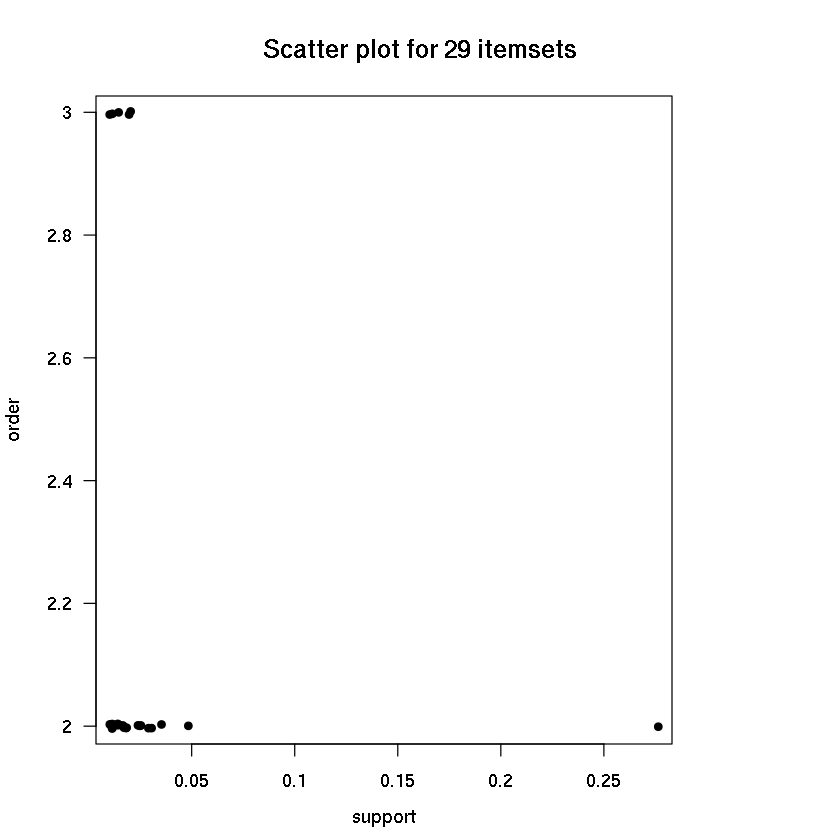

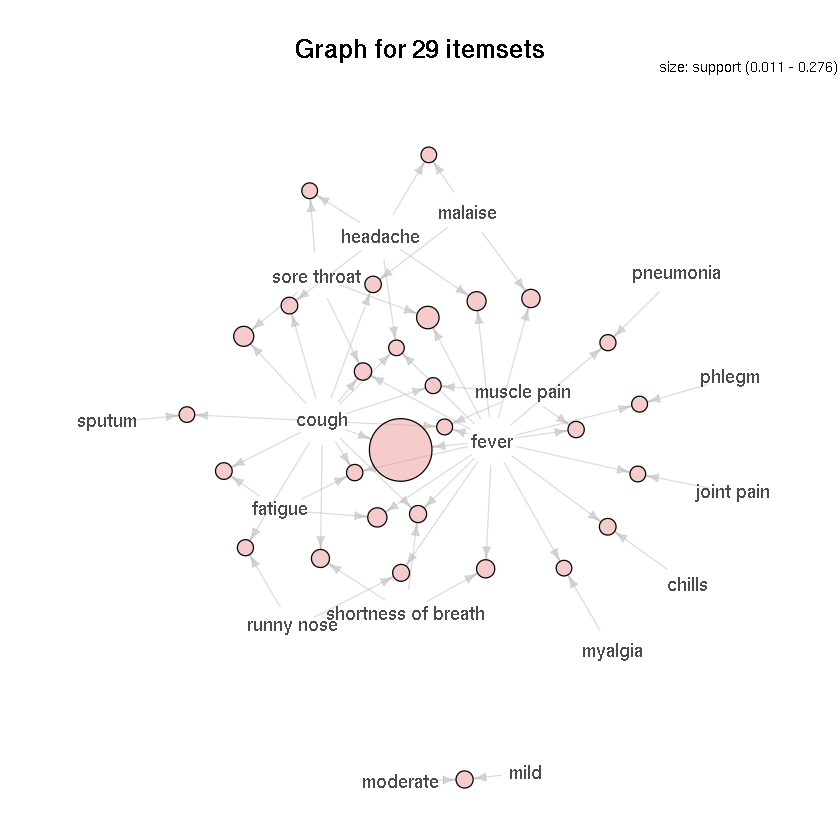

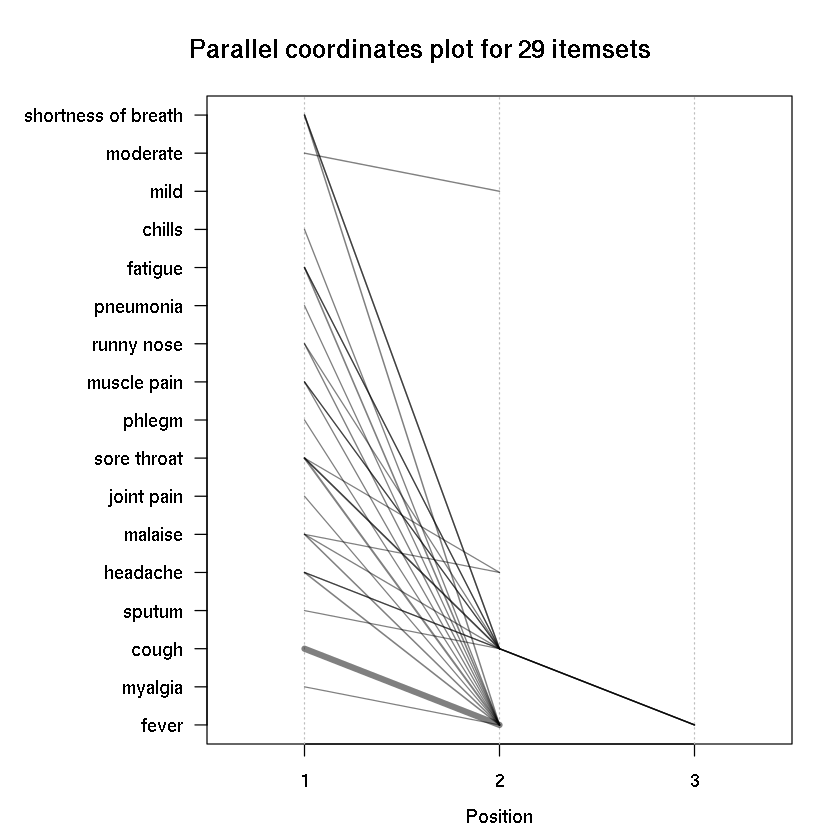

In [5]:
itemsets <- eclat(symptom_data_transactions, parameter = list(support = 0.01, minlen=2))
plot(itemsets)
plot(itemsets, method="graph")
plot(itemsets, method="paracoord", control=list(alpha=.5, reorder=TRUE))

# Graph rules

pdf 
  3

png 
  2

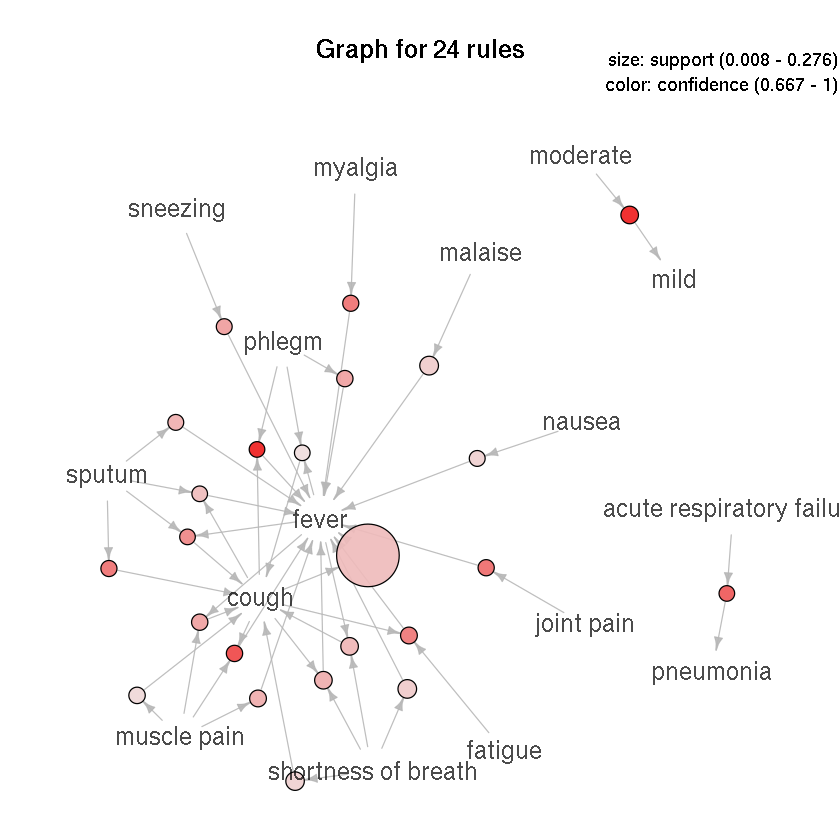

In [73]:
#plot(symptom_rules, method="graph", control=list(layout=igraph::in_circle()))
#plot(symptom_rules, method="graph", control=list(layout=igraph::with_graphopt(spring.const=1, mass=100)))

set.seed(11)
plot(symptom_rules, method="graph", cex=1.3, measure="support", shading="confidence", alpha=0.9)
dev.copy(pdf, "symptoms-rules.pdf")
dev.off()